In [1]:
import uproot
import pandas as pd
import numpy as np
#import matplotlib.pyplot
#import os
#import ROOT
import pylhe
#import heapq
import matplotlib.pyplot as plt
import math

In [2]:
# Function to calculate rapidity
def pr(p):
    pz = getattr(p, 'pz')
    p_total = np.sqrt(getattr(p, 'px')**2 + getattr(p, 'py')**2 + pz**2)

    if p_total == 0:
        return 0
    else:
        pr = 0.5 * np.log((p_total + pz) / (p_total - pz))
        return pr
    
    

def calculate_phiR(p1, p2):
    # Calculate the azimuthal angles for both particles
    phi1 = np.arctan2(p1.py, p1.px)
    phi2 = np.arctan2(p2.py, p2.px)
    

    # Calculate the angular separation ∆\phi in the transverse plane
    phiR = np.abs(phi1 - phi2)

    # Ensure ∆\phi is between 0 and π
    #phiR = np.where(phiR > np.pi, 2 * np.pi - phiR, phiR)

    return phiR


def calculate_phiR1(p1):
    # Calculate the azimuthal angles for both particles
    phi1 = np.arctan2(p1.py, p1.px)
    
    

    # Calculate the angular separation ∆\phi in the transverse plane
    phiR1 = phi1

    # Ensure ∆\phi is between 0 and π
    #phiR1 = np.where(phiR1 > np.pi, 2 * np.pi - phiR1, phiR1)

    return phiR1

def invariant_mass(p1,p2):
    return math.sqrt(sum((1 if mu=='e' else -1
    )*(getattr(p1,mu)+getattr(p2,mu))**2 for mu in [
    'e','px','py','pz']))


def pt(p1):
    return math.sqrt(sum((getattr(p1,mu))**2 for mu in ['px','py']))


def smear(p, delta1, delta2):
    E = p[0]
    sigma = np.sqrt((delta1 * np.sqrt(E))**2 + (delta2 * E)**2)

    while True:
        Ep = gauss(E, sigma)
        if Ep >= 0:
            break

    smeared_p = [p[i] * Ep / E for i in range(4)]
    return smeared_p

def gauss(mean, std_dev):
    while True:
        v1 = 2.0 * np.random.random() - 1.0
        v2 = 2.0 * np.random.random() - 1.0
        s = v1**2 + v2**2

        if s < 1.0:
            x = v1 * np.sqrt(-2.0 * np.log(s) / s)
            return x * std_dev + mean

delta1 = 0.2
delta2 = 0.01

In [4]:
data = pylhe.readLHE("/root/MG5_aMC_v2_7_3/ALP01/Events/run_03/unweighted_events.lhe")
D1, D2, Ra1,PT_l,PT_b,eta_l,eta_b, PJ_p, PhiJ = [],[],[],[],[],[],[],[],[]
for event1 in data:
    # Get transverse momenta (pt) for both photons
    pt1 = pt(event1.particles[-1])
    pt2 = pt(event1.particles[-2])
    Rj = pr(event1.particles[-6])
    Pj = pt(event1.particles[-6])
    phij=calculate_phiR1(event1.particles[-6])
    
    pt_l = pt(event1.particles[-3])
    pt_b = pt(event1.particles[-5])
    R_l = pr(event1.particles[-3])
    R_b = pr(event1.particles[-5])
    

    # Determine leading and subleading photons based on pt
    if pt1 > pt2:
        leading_photon = (pt1, pr(event1.particles[-1]))
        subleading_photon = (pt2, pr(event1.particles[-2]))
    else:
        leading_photon = (pt2, pr(event1.particles[-2]))
        subleading_photon = (pt1, pr(event1.particles[-1]))

    # Append leading and subleading photons to D1 and D2 lists
    D1.append(leading_photon)
    D2.append(subleading_photon)
    Ra1.append(Rj)
    PT_l.append(pt_l)
    PT_b.append(pt_b)
    eta_l.append(R_l)
    eta_b.append(R_b)
    PJ_p.append(Pj)
    PhiJ.append(phij)

In [5]:
file2=uproot.open("/root/MG5_aMC_v2_7_3/ALP01/Events/run_03/tag_1_delphes_events.root")["Delphes"]
Cut_flow1 = pd.DataFrame({
    "PJ":pd.DataFrame(file2["Jet.PT"].array())[0],
    "EJ":pd.DataFrame(file2["Jet.Eta"].array())[0],
    "AJ":pd.DataFrame(file2["Jet.Phi"].array())[0],
    "PPH":pd.DataFrame(file2["Photon.PT"].array())[0],
    "EPH":pd.DataFrame(file2["Photon.Eta"].array())[0]
})

PJ=np.array(Cut_flow1["PJ"])
EJ=np.array(Cut_flow1["EJ"])
AJ=np.array(Cut_flow1["AJ"])
PPH=np.array(Cut_flow1["PPH"])
EPH=np.array(Cut_flow1["EPH"])

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


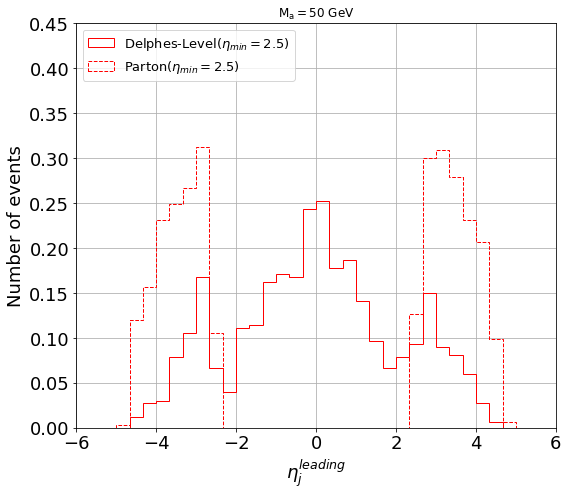

In [6]:
bins = 60
fs=18 # front size
tagsize = 18 # label tag size
plt.figure(figsize=(8,7)) # plotsize
x1, x2 = -10, 10 # x region

#1 subplot
plt.hist(EJ, bins=bins, histtype='step',color='r',density=True,range=[x1, x2], label='Delphes-Level($\\eta_{min}=2.5$)')
plt.hist(Ra1, bins=bins, histtype='step',linestyle='dashed',color='r',density=True,range=[x1, x2], label='Parton($\\eta_{min}=2.5$)')

plt.legend(fontsize=13,loc='upper left') # plot label tag
#plt.yscale('log') 
#plt.xscale('log')
plt.xlabel('$\\eta_j^{leading}$' , fontsize=fs)  # plot x-axis label
plt.ylabel("Number of events", fontsize=fs)  # plot y-axis label
plt.xticks(fontsize=fs)   # set x-ticks size
plt.yticks(fontsize=fs)   # set y-ticks size
plt.xlim(-6,6)
plt.ylim(0,0.45)
plt.title("$\\rm M_{a}=50~GeV$")
plt.tight_layout()

plt.grid()

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


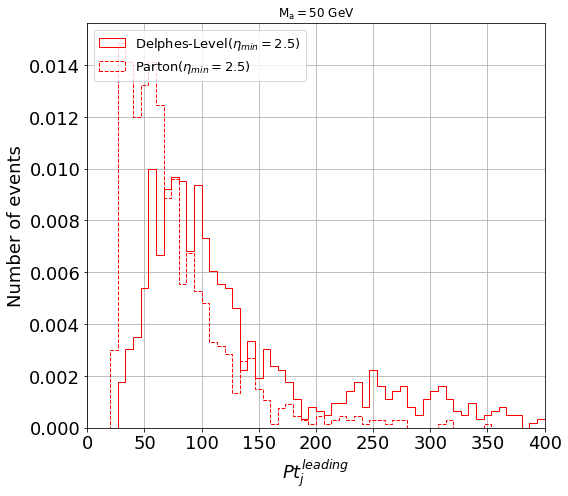

In [10]:
bins = 60
fs=18 # front size
tagsize = 18 # label tag size
plt.figure(figsize=(8,7)) # plotsize
x1, x2 = 0, 400 # x region

#1 subplot
plt.hist(PJ, bins=bins, histtype='step',color='r',density=True,range=[x1, x2], label='Delphes-Level($\\eta_{min}=2.5$)')
plt.hist(PJ_p, bins=bins, histtype='step',linestyle='dashed',color='r',density=True,range=[x1, x2], label='Parton($\\eta_{min}=2.5$)')

plt.legend(fontsize=13,loc='upper left') # plot label tag
#plt.yscale('log') 
#plt.xscale('log')
plt.xlabel('$Pt_j^{leading}$' , fontsize=fs)  # plot x-axis label
plt.ylabel("Number of events", fontsize=fs)  # plot y-axis label
plt.xticks(fontsize=fs)   # set x-ticks size
plt.yticks(fontsize=fs)   # set y-ticks size
plt.xlim(0,400)
#plt.ylim(0,0.45)
plt.title("$\\rm M_{a}=50~GeV$")
plt.tight_layout()

plt.grid()

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


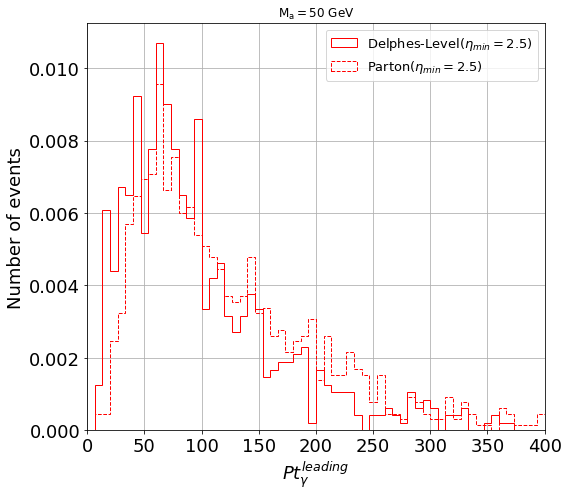

In [8]:
bins = 60
fs=18 # front size
tagsize = 18 # label tag size
plt.figure(figsize=(8,7)) # plotsize
x1, x2 = 0, 400 # x region

#1 subplot
plt.hist(PPH, bins=bins, histtype='step',color='r',density=True,range=[x1, x2], label='Delphes-Level($\\eta_{min}=2.5$)')
plt.hist([x[0] for x in D1], bins=bins, histtype='step',linestyle='dashed',color='r',density=True,range=[x1, x2], label='Parton($\\eta_{min}=2.5$)')

plt.legend(fontsize=13,loc='upper right') # plot label tag
#plt.yscale('log') 
#plt.xscale('log')
plt.xlabel('$Pt_\\gamma^{leading}$' , fontsize=fs)  # plot x-axis label
plt.ylabel("Number of events", fontsize=fs)  # plot y-axis label
plt.xticks(fontsize=fs)   # set x-ticks size
plt.yticks(fontsize=fs)   # set y-ticks size
plt.xlim(0,400)
#plt.ylim(0,0.45)
plt.title("$\\rm M_{a}=50~GeV$")
plt.tight_layout()

plt.grid()

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


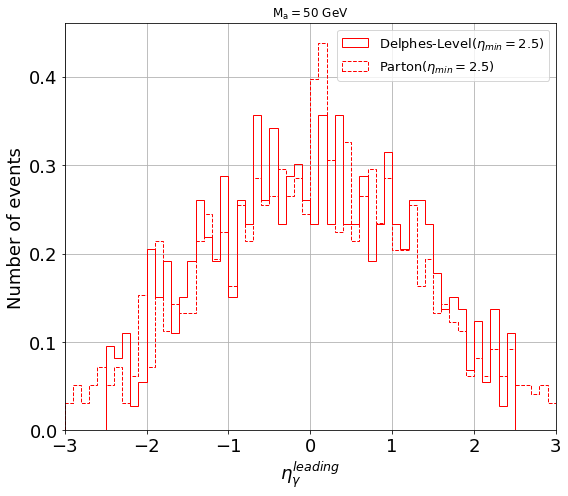

In [9]:
bins = 60
fs=18 # front size
tagsize = 18 # label tag size
plt.figure(figsize=(8,7)) # plotsize
x1, x2 = -3,3 # x region

#1 subplot
plt.hist(EPH, bins=bins, histtype='step',color='r',density=True,range=[x1, x2], label='Delphes-Level($\\eta_{min}=2.5$)')
plt.hist([x[1] for x in D1], bins=bins, histtype='step',linestyle='dashed',color='r',density=True,range=[x1, x2], label='Parton($\\eta_{min}=2.5$)')

plt.legend(fontsize=13,loc='upper right') # plot label tag
#plt.yscale('log') 
#plt.xscale('log')
plt.xlabel('$\\eta_\\gamma^{leading}$' , fontsize=fs)  # plot x-axis label
plt.ylabel("Number of events", fontsize=fs)  # plot y-axis label
plt.xticks(fontsize=fs)   # set x-ticks size
plt.yticks(fontsize=fs)   # set y-ticks size
plt.xlim(-3,3)
#plt.ylim(0,0.45)
plt.title("$\\rm M_{a}=50~GeV$")
plt.tight_layout()

plt.grid()